In [ ]:
import pandas as pd

# Load the dataset from an Excel file into a pandas DataFrame
file_path = '/content/SP_7JXQ_A_no-H2O_1cons_M1-div_arm_hb_16rota_new-smiles_dedup_full_columns_sample.xlsx'
df = pd.read_excel(file_path)
print(f"Original dataset size:",df.shape)
# Remove duplicate entries
df = df.drop_duplicates()
print(f"Dataset size after removing duplicates: {df.shape}")
threshold = 0.8  # Threshold of 80% missing values
df_cleaned = df.dropna(axis='columns', thresh=int(threshold * len(df)))
# Shape of the new dataset
print(f"Dataset size after handling missing values:", df_cleaned.shape)


Original dataset size: (999, 438)
Dataset size after removing duplicates: (999, 438)
Dataset size after handling missing values: (999, 351)


In [ ]:
!pip install rdkit-pypi

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:  # SMILES parsing check
        return [None] * 4  # Adjust the number if you change the number of descriptors
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]

# Function to compute ECFP (Morgan) fingerprints
def compute_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:  # SMILES parsing check
        return [None] * 2048  # Adjust if you change the fingerprint length
    return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))

# Assuming 'df' is your DataFrame and 'SMILES' is the column with the molecular data

# Ensure all SMILES data are strings and filter out any rows where SMILES might be NaN or improper format
df['SMILES'] = df['SMILES'].astype(str)
df = df[df['SMILES'] != 'nan']

# Creating new DataFrame columns for descriptors
descriptor_names = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']
descriptors = df['SMILES'].apply(lambda x: pd.Series(compute_descriptors(x), index=descriptor_names))

# Creating new DataFrame columns for fingerprints
fingerprint_names = [f'Bit_{i}' for i in range(2048)]  # Naming bits for clarity
fingerprints = df['SMILES'].apply(lambda x: pd.Series(compute_fingerprints(x), index=fingerprint_names))

# Concatenating all features (descriptors and fingerprints) with the original DataFrame
full_features_df = pd.concat([df, descriptors, fingerprints], axis=1)
# Print the first few rows of the descriptors dataframe
print("First few rows of molecular descriptors:")
print(descriptors.head())

# Print the first few rows of the fingerprints dataframe
print("First few rows of molecular fingerprints:")
print(fingerprints.head())
# Assuming 'df' contains your original data including 'Docking Score'
# and 'descriptors' and 'fingerprints' are your feature DataFrames
combined_df = pd.concat([df, descriptors, fingerprints], axis=1)



First few rows of molecular descriptors:
     MolWt     LogP  NumHDonors  NumHAcceptors
1  422.532  5.46710         3.0            2.0
2  494.667  5.14340         1.0            7.0
3  434.499  5.91494         1.0            6.0
4  488.931  3.60720         2.0            4.0
5  464.500  4.93560         1.0            4.0
First few rows of molecular fingerprints:
   Bit_0  Bit_1  Bit_2  Bit_3  Bit_4  Bit_5  Bit_6  Bit_7  Bit_8  Bit_9  ...  \
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   
5      0      0      0      0      0      0      0      0      0      0  ...   

   Bit_2038  Bit_2039  Bit_2040  Bit_2041  Bit_2042  Bit_2043  Bit_2044  \
1         0         0         0         0         0         0         0   
2   

In [ ]:
# Print all column names in the DataFrame
all_columns = list(combined_df.columns)
print(all_columns)


['Stars', 'Title', 'Entry ID', 'Entry Name', 'Date Added', 'Date Modified', 'converted selenomethionines', 'created disulfur', 'prepared', 'Source File Index', 'PDB CRYST1 z', 'EEKEYHAEGG Homology Similarity', 'EEKEYHAEGG Homology Stem Beta', 'EEKEYHAEGG Homology Stem Dist', 'EEKEYHAEGG Homology Stem Gamma', 'EKEYHAEGGK Homology Similarity', 'EKEYHAEGGK Homology Stem Beta', 'EKEYHAEGGK Homology Stem Dist', 'EKEYHAEGGK Homology Stem Gamma', 'GAEEKEYHAEGG Homology Similarity', 'GAEEKEYHAEGG Homology Stem Beta', 'GAEEKEYHAEGG Homology Stem Dist', 'GAEEKEYHAEGG Homology Stem Gamma', 'Bend Energy-S-OPLS', 'Dihedral Energy-S-OPLS', 'El-14 Energy-S-OPLS', 'Electrostatic Energy-S-OPLS', 'LJ-14 Energy-S-OPLS', 'Max Derivative-S-OPLS', 'Potential Energy-S-OPLS', 'RMS Derivative-S-OPLS', 'Stretch Energy-S-OPLS', 'Van der Waals Energy-S-OPLS', 'target temperature', 'PDB CRYST1 a', 'PDB CRYST1 alpha', 'PDB CRYST1 b', 'PDB CRYST1 beta', 'PDB CRYST1 c', 'PDB CRYST1 gamma', 'PDB EXPDTA PH', 'PDB EXPDT

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Assuming combined_df is your initial DataFrame

# Remove columns with all NaN values
numeric_features = combined_df.select_dtypes(include=[np.number])
numeric_features = numeric_features.dropna(axis=1, how='all')

# Impute missing values in numeric_features
# Here, we use the median for imputation, but you can choose another strategy
imputer = SimpleImputer(strategy='median')
numeric_features_imputed = imputer.fit_transform(numeric_features)
numeric_features_imputed_df = pd.DataFrame(numeric_features_imputed, columns=numeric_features.columns)

# Separate the target variable
if 'docking score' in combined_df.columns:
    targets = combined_df['docking score']
else:
    targets = None
    print("Target column 'docking score' was not found or defined, please verify your dataset.")

# Normalize the numeric features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(numeric_features_imputed_df)
normalized_features_df = pd.DataFrame(normalized_features, columns=numeric_features_imputed_df.columns)

# Normalize the 'docking score', if it exists
if targets is not None:
    # Impute missing values in targets if necessary
    targets_imputed = imputer.fit_transform(targets.values.reshape(-1, 1)).flatten()
    target_scaler = MinMaxScaler()
    normalized_targets = target_scaler.fit_transform(targets_imputed.reshape(-1, 1)).flatten()
# Display the first few rows of the normalized features
print("Normalized Features:")
print(normalized_features_df.head())

# If the target variable exists and was normalized, display it as well
if 'docking score' in combined_df.columns:
    # Create a DataFrame for the normalized targets for easy viewing
    normalized_targets_df = pd.DataFrame(normalized_targets, columns=['Normalized Docking Score'])
    print("\nNormalized Target Variable ('docking score'):")
    print(normalized_targets_df.head())
else:
    print("Target column 'docking score' was not found or defined, please verify your dataset.")



Normalized Features:
   Entry ID  Source File Index  mmshare version  flags  Ionization Penalty  \
0  0.000000           0.000000              0.0    0.0            0.001004   
1  0.000998           0.000998              0.0    0.0            0.005659   
2  0.001996           0.001996              0.0    0.0            0.000026   
3  0.002994           0.002994              0.0    0.0            0.004937   
4  0.003992           0.003992              0.0    0.0            0.000000   

   Ionization Penalty Charging  Ionization Penalty Neutral  State Penalty  \
0                          0.0                    0.009379       0.010340   
1                          0.0                    0.052855       0.058269   
2                          0.0                    0.000244       0.000000   
3                          0.0                    0.046114       0.032420   
4                          0.0                    0.000000       0.000000   

   Charging Adjusted Penalty  Tot Q  ...  Bit_2

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(normalized_features_df, test_size = 0.2, random_state=20)
valid, test = train_test_split(test, test_size = 0.5, random_state=20)

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Determine the number of input features. This should match the number of columns in your training data.
n_features = normalized_features_df.shape[1]

# Initialize the model
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(units=1024, activation='relu', input_shape=(n_features,)))

# Adding the second hidden layer
model.add(Dense(units=512, activation='relu'))

# Adding the output layer - since it's a regression problem, we have one output and no activation function
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Split your normalized_features_df and normalized_targets into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(normalized_features_df, normalized_targets, test_size=0.2, random_state=20)

# Training the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Optionally, evaluate the model on a test set if you have withheld one
# model.evaluate(test_features, test_targets)


Epoch 1/100
25/25 [==============================] - 3s 76ms/step - loss: 0.6866 - val_loss: 0.0514
Epoch 2/100
25/25 [==============================] - 2s 86ms/step - loss: 0.0254 - val_loss: 0.0230
Epoch 3/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0157 - val_loss: 0.0205
Epoch 4/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0112 - val_loss: 0.0178
Epoch 5/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0073 - val_loss: 0.0165
Epoch 6/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0053 - val_loss: 0.0156
Epoch 7/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0032 - val_loss: 0.0130
Epoch 8/100
25/25 [==============================] - 3s 102ms/step - loss: 0.0021 - val_loss: 0.0123
Epoch 9/100
25/25 [==============================] - 2s 90ms/step - loss: 0.0016 - val_loss: 0.0136
Epoch 10/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0015 - val_loss: 0.011

Explanation:
Model Initialization: We use a Sequential model, which is a linear stack of layers.
Input Layer: The first Dense layer acts as your input layer, with the input_shape parameter set to match the number of features in your dataset.
Hidden Layers: Two hidden layers are included, with 1024 and 512 neurons, respectively, using ReLU activation functions to introduce non-linearity.
Output Layer: For a regression problem, the output layer has one neuron and does not use an activation function, as we're predicting a continuous value.
Compilation: The model uses the Adam optimizer and mean squared error as the loss function, which are common choices for regression problems.
Training: The model is trained using the training data, with validation data provided to monitor performance on unseen data. The epochs parameter determines how many times the model will iterate over the entire dataset, and batch_size controls the number of samples per gradient update.
This setup is a starting point. Based on your model's performance, you may want to experiment with different architectures, activation functions, optimizers, and learning rates to improve results.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


# Assuming normalized_features_df and normalized_targets are defined and preprocessed


from sklearn.model_selection import train_test_split


# Assuming normalized_features_df and normalized_targets are defined


# First, split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
   normalized_features_df, normalized_targets, test_size=0.2, random_state=20)


# Now split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
   X_train_val, y_train_val, test_size=0.25, random_state=20)  # 0.25 x 0.8 = 0.2


# Now you have:
# - Training set: X_train, y_train
# - Validation set: X_val, y_val
# - Test set: X_test, y_test


# The proportions of the splits will be:
# 60% training, 20% validation, 20% test




# Your model definition and training code here


# Evaluate the model on the validation set
loss = model.evaluate(X_val, y_val)


# Predicting the values for validation set
y_pred = model.predict(X_val)


# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)


# Calculating R^2 Score
r2 = r2_score(y_val, y_pred)


print(f'Mean Squared Error on Validation Set: {loss}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R^2 Score on Validation Set: {r2}')


7/7 [==============================] - 0s 15ms/step
Mean Squared Error on Validation Set: 0.006216417532414198
Mean Absolute Error on Validation Set: 0.05024004007016978
R^2 Score on Validation Set: 0.782910132024304



Epoch 1: LearningRateScheduler setting learning rate to 0.0002465970173943788.
Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 2.9273e-05

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 88ms/step - loss: 2.9119e-05 - val_loss: 0.0062 - lr: 2.4660e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002465970173943788.
Epoch 2/100
25/25 [==============================] - 2s 75ms/step - loss: 1.2970e-05 - val_loss: 0.0063 - lr: 2.4660e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0002465970173943788.
Epoch 3/100
25/25 [==============================] - 2s 79ms/step - loss: 8.1131e-06 - val_loss: 0.0062 - lr: 2.4660e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0002465970173943788.
Epoch 4/100
25/25 [==============================] - 3s 118ms/step - loss: 6.3546e-06 - val_loss: 0.0062 - lr: 2.4660e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0002465970173943788.
Epoch 5/100
25/25 [==============================] - 2s 62ms/step - loss: 6.2184e-06 - val_loss: 0.0062 - lr: 2.4660e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0002465970173943788.
Epoch 

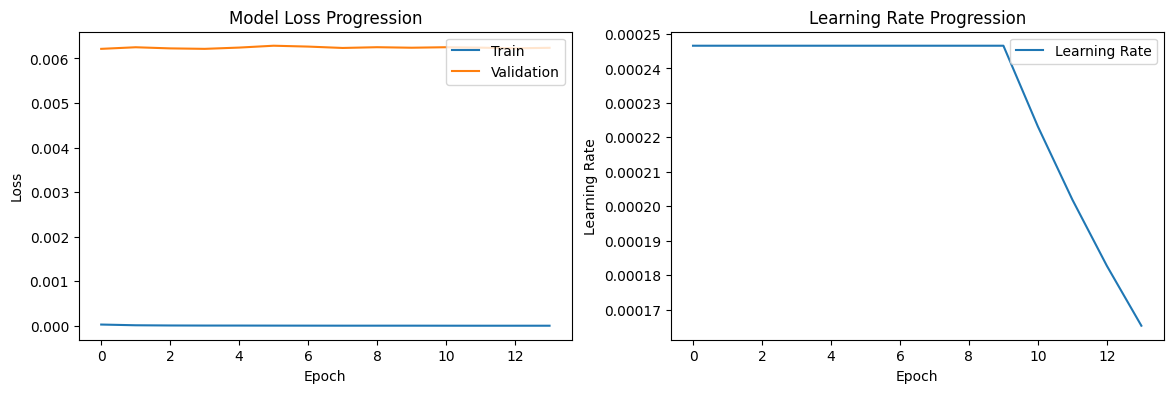

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import os
import matplotlib.pyplot as plt

# Define a simple schedule to decrease the learning rate gradually
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    LearningRateScheduler(scheduler, verbose=1)
]

# Assuming you have the Sequential model defined as 'model' and compiled

# Train the model with the enhancements
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, verbose=1,
                    callbacks=callbacks)

# Plotting the training and validation loss, including learning rate over epochs
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['lr'], label='Learning Rate')
plt.title('Learning Rate Progression')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [ ]:
# This is the best epoch number
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"The best model was obtained after {best_epoch} epochs")


The best model was obtained after 4 epochs


Additional Notes:
Early Stopping: patience=10 means training will stop if the validation loss does not improve for 10 consecutive epochs. restore_best_weights=True ensures the model reverts to its state from when it achieved the best validation loss.
Model Checkpoints: This saves the best version of your model based on validation loss. Ensure the directory for filepath exists or is writable.
Learning Rate Scheduler: The defined scheduler function decreases the learning rate after 10 epochs. Adjust this strategy based on your observations of the training process.
Plot Adjustments: The second subplot visualizes the learning rate over epochs, helping you understand how the learning rate changes over time due to the scheduler.
By integrating these strategies, you can more effectively manage the training process, potentially leading to better model performance and efficiency.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming normalized_features_df and normalized_targets are defined and preprocessed

from sklearn.model_selection import train_test_split

# Assuming normalized_features_df and normalized_targets are defined

# First, split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    normalized_features_df, normalized_targets, test_size=0.2, random_state=20)

# Now split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=20)  # 0.25 x 0.8 = 0.2

# Now you have:
# - Training set: X_train, y_train
# - Validation set: X_val, y_val
# - Test set: X_test, y_test

# The proportions of the splits will be:
# 60% training, 20% validation, 20% test


# Your model definition and training code here

# Evaluate the model on the validation set
loss = model.evaluate(X_val, y_val)

# Predicting the values for validation set
y_pred = model.predict(X_val)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)

# Calculating R^2 Score
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error on Validation Set: {loss}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R^2 Score on Validation Set: {r2}')


7/7 [==============================] - 1s 38ms/step
Mean Squared Error on Validation Set: 0.0011004761327058077
Mean Absolute Error on Validation Set: 0.02488717759413263
R^2 Score on Validation Set: 0.9511603412112293


In [ ]:
# Combine the original training and validation sets for the final training phase
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

In [ ]:
# Initialize the model (this should be the architecture of your best model)
model = Sequential()
model.add(Dense(units=1024, activation='relu', input_shape=(n_features,)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Retrain the model on the combined training and validation set
model.fit(X_train_val, y_train_val, epochs=best_epoch, batch_size=32)

# Now, evaluate the model on the test set (assuming X_test, y_test are your test features and targets)
loss_on_test = model.evaluate(X_test, y_test)

# Predict the test set results
y_pred_test = model.predict(X_test)

# Calculate Mean Squared Error (MSE) on test set
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_test)

# Calculating R^2 Score
r2 = r2_score(y_test, y_pred_test)

print(f'Mean Squared Error on Test Set: {mse_test}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R^2 Score on Test Set: {r2}')

Epoch 1/4
25/25 [==============================] - 3s 58ms/step - loss: 0.4091
Epoch 2/4
25/25 [==============================] - 1s 37ms/step - loss: 0.0203
Epoch 3/4
25/25 [==============================] - 1s 37ms/step - loss: 0.0133
Epoch 4/4
7/7 [==============================] - 0s 8ms/step
Mean Squared Error on Test Set: 0.017089145768085134
Mean Absolute Error on Test Set: 0.09740753419600522
R^2 Score on Test Set: 0.4032124644643761
